In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

In [20]:
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [21]:
def prepare_clustering_features():
    customer_features = pd.DataFrame()
    
    customer_features['CustomerID'] = customers_df['CustomerID']
    
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    customer_features['DaysSinceSignup'] = (pd.Timestamp('2024-12-31') - 
                                          customers_df['SignupDate']).dt.days
    
    transaction_stats = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean'],
        'Quantity': 'sum'
    }).fillna(0)
    
    transaction_stats.columns = ['TransactionCount', 'TotalSpend', 'AvgPurchaseValue', 'TotalQuantity']
    
    # Merge transaction stats with customer features
    customer_features = customer_features.merge(
        transaction_stats, 
        left_on='CustomerID',
        right_index=True,
        how='left'
    ).fillna(0)
    
    # Calculate purchase frequency
    customer_features['PurchaseFrequency'] = (
        customer_features['TransactionCount'] / 
        np.maximum(customer_features['DaysSinceSignup'], 1)  
    )
    
    region_dummies = pd.get_dummies(customers_df['Region'], prefix='Region')
    customer_features = pd.concat([customer_features, region_dummies], axis=1)
    
    return customer_features

In [22]:
def perform_clustering_analysis(features, n_clusters_range=range(2, 11)):
    features_for_clustering = features.drop('CustomerID', axis=1)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_for_clustering)
    

    metrics = []
    
    # Try different numbers of clusters
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(scaled_features)
        
        # Calculate metrics
        db_index = davies_bouldin_score(scaled_features, cluster_labels)
        silhouette = silhouette_score(scaled_features, cluster_labels)
        
        metrics.append({
            'n_clusters': n_clusters,
            'db_index': db_index,
            'silhouette': silhouette,
            'labels': cluster_labels,
            'model': kmeans
        })
        
        print(f"Clusters: {n_clusters}, DB Index: {db_index:.4f}, Silhouette: {silhouette:.4f}")
    
    return metrics, scaled_features

In [23]:
def plot_metrics(metrics):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    n_clusters = [m['n_clusters'] for m in metrics]
    db_scores = [m['db_index'] for m in metrics]
    silhouette_scores = [m['silhouette'] for m in metrics]
    
    # Davies-Bouldin Index
    ax1.plot(n_clusters, db_scores, 'bo-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Davies-Bouldin Index')
    ax1.set_title('Davies-Bouldin Index vs Number of Clusters')
    
    # Silhouette Score
    ax2.plot(n_clusters, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score vs Number of Clusters')
    
    plt.tight_layout()
    plt.show()

In [24]:
def plot_clusters(scaled_features, labels, features):
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)
    

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('Customer Segments (PCA Visualization)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()
    
    features_with_clusters = features.copy()
    features_with_clusters['Cluster'] = labels
    
    cluster_profiles = features_with_clusters.groupby('Cluster').agg({
        'TransactionCount': 'mean',
        'TotalSpend': 'mean',
        'AvgPurchaseValue': 'mean',
        'TotalQuantity': 'mean',
        'PurchaseFrequency': 'mean'
    }).round(2)
    
   
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        cluster_profiles,
        annot=True,
        fmt='.2f',
        cmap='YlOrRd'
    )
    plt.title('Cluster Characteristics Heatmap')
    plt.show()
    
    return cluster_profiles

In [25]:
def run_clustering_analysis():
    print("Preparing features...")
    features = prepare_clustering_features()
    
    print("\nPerforming clustering analysis...")
    metrics, scaled_features = perform_clustering_analysis(features)
    
    print("\nPlotting metrics...")
    plot_metrics(metrics)
    
    optimal_clustering = min(metrics, key=lambda x: x['db_index'])
    print(f"\nOptimal number of clusters: {optimal_clustering['n_clusters']}")
    print(f"Davies-Bouldin Index: {optimal_clustering['db_index']:.4f}")
    print(f"Silhouette Score: {optimal_clustering['silhouette']:.4f}")
    
    print("\nVisualizing optimal clusters...")
    cluster_profiles = plot_clusters(
        scaled_features,
        optimal_clustering['labels'],
        features
    )
    
    return optimal_clustering, cluster_profiles

Preparing features...

Performing clustering analysis...
Clusters: 2, DB Index: 1.8914, Silhouette: 0.1936
Clusters: 3, DB Index: 1.6619, Silhouette: 0.2085
Clusters: 4, DB Index: 1.3129, Silhouette: 0.3326
Clusters: 5, DB Index: 1.0410, Silhouette: 0.3408
Clusters: 6, DB Index: 0.9753, Silhouette: 0.3256
Clusters: 7, DB Index: 0.9988, Silhouette: 0.3216
Clusters: 8, DB Index: 1.0507, Silhouette: 0.3215
Clusters: 9, DB Index: 1.0291, Silhouette: 0.3065
Clusters: 10, DB Index: 1.0728, Silhouette: 0.2921

Plotting metrics...


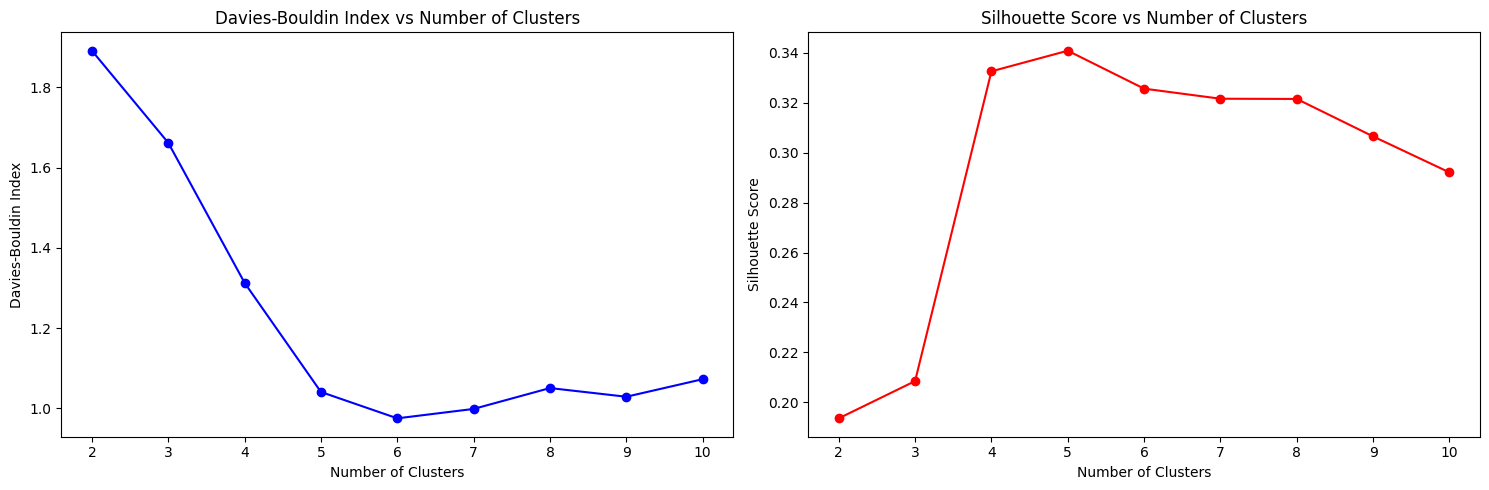


Optimal number of clusters: 6
Davies-Bouldin Index: 0.9753
Silhouette Score: 0.3256

Visualizing optimal clusters...


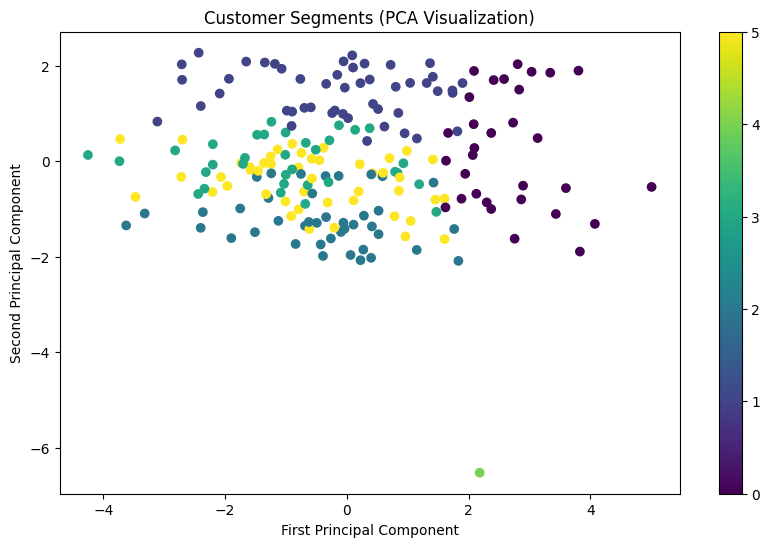

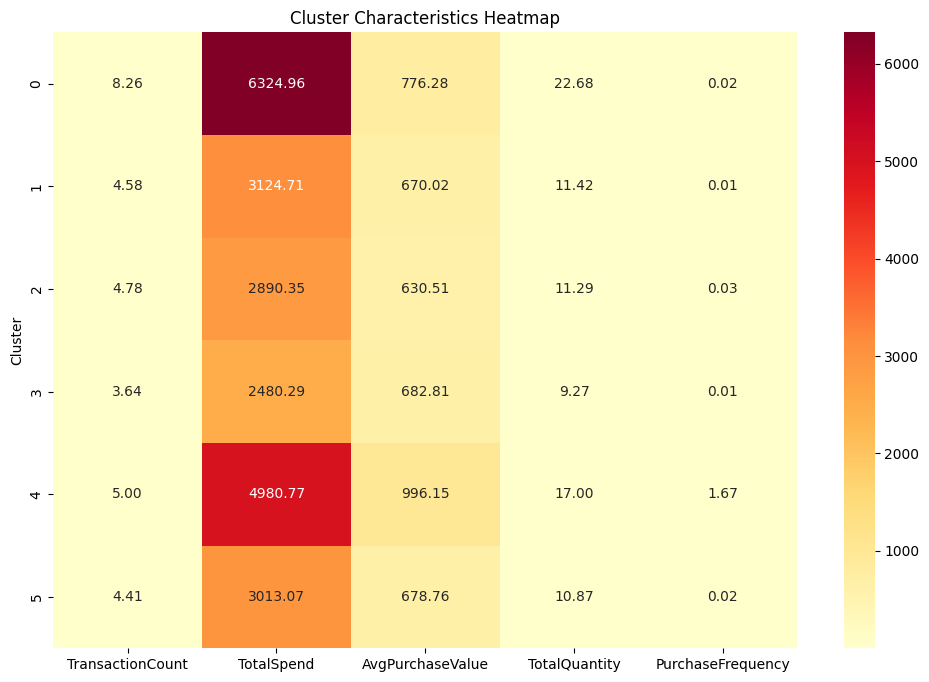


Cluster Profiles:


,TransactionCount,TotalSpend,AvgPurchaseValue,TotalQuantity,PurchaseFrequency
Cluster,,,,,
0,8.26,6324.96,776.28,22.68,0.02
1,4.58,3124.71,670.02,11.42,0.01
2,4.78,2890.35,630.51,11.29,0.03
3,3.64,2480.29,682.81,9.27,0.01
4,5.00,4980.77,996.15,17.00,1.67
5,4.41,3013.07,678.76,10.87,0.02


In [26]:
optimal_clustering, cluster_profiles = run_clustering_analysis()


print("\nCluster Profiles:")
display(cluster_profiles)


In [29]:
cluster_sizes = pd.Series(optimal_clustering['labels']).value_counts().sort_index()
print("\nCluster Sizes:")
display(cluster_sizes)


Cluster Sizes:


0    31
1    48
2    41
3    33
4     1
5    46
Name: count, dtype: int64